In [184]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem.rdmolfiles import SDMolSupplier
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
import re
import random

In [185]:
#1: This program shows how to extract a library of bipyridine sidechains from an open-source csv file containg about 
#   10 000 bipyridine ligand

In [186]:
#First step: extract the bipyridines from the csv file and convert it into a list of Rd-kit Mol objects
df=pd.read_csv('/Users/tarrago/Downloads/PubChem_compound_text_bipyridine_summary.csv')
suppl=df['isosmiles'].values
mol=[]
for m1 in suppl:
    Dumdum=Chem.MolFromSmiles(m1)
    mol.append(Dumdum)

RDKit WARNING: [13:57:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:24] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [13:57:25] Explicit valence

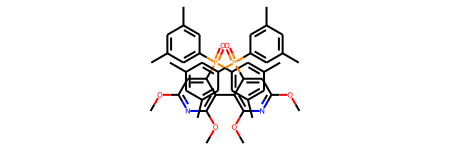

In [187]:
# the list mol contains 11410 bipyridine. However, some of them are counted twice, some of them don't actually
# contain bipyridines, and some of them contain
# two molecules or more. In the next step, we want to get rid of the intruder molecules, not containing any 
#2,2-bipyridine. For instance:
mol[11]

In [188]:
# So here is a chunk of code to get rid of all non-conform objects:
sub=Chem.MolFromSmiles('C1=CC=NC(=C1)C2=CC=CC=N2')
ndoubles=[]
print(len(mol))
i=0
while i < len(mol):
    # Here the code gets rid of all objects containing either nothing, or no 2,2-bipyridine
    if str((type(mol[i]))) != "<class 'rdkit.Chem.rdchem.Mol'>":
        mol.remove(mol[i])
    elif len(mol[i].GetSubstructMatches(sub)) == 0:
        mol.remove(mol[i])
    else:
        S1=Chem.MolToSmiles(mol[i])
        # This part gets rid of the extra molecules if there are more than one molecule in the fragment. Note that
        # if several bipyridines are present in the object, only the last one will be kept.
        if "." in S1:
            Split=S1.split('.')
            for j in range(0,len(Split)):
                dumdum=Chem.MolFromSmiles(Split[j])
                if len(dumdum.GetSubstructMatches(sub)) == 1:
                    mol[i]=dumdum
  
        i = i+1


11410


RDKit WARNING: [13:57:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:42] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:42] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:42] WARNING: not r

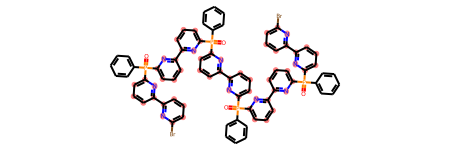

In [190]:
#Finally, for simplicity reason, we want to get rid of complicated motifs involving several bipyridines. That is because,
# in the end, we simply want to constitute a library of sidechains with only one attachment point. Example of non conform
# molecule here:
mol[17]

In [191]:
i=0
while i < len(mol):
    if len(mol[i].GetSubstructMatches(sub)) > 1 :
        mol.remove(mol[i])
    else:
        i=i+1
len(mol)

5980

In [218]:
# There are still possible duplicates at this point. However, since we will get rid of the duplicates also once we
# have extracted the sidechains, we do not care. 
#For now, let us focus on extracting the side chains. Of note, the following code fails for 12 exceptions (709,710, 924,
# 1702,1704, 2180, 3777,3778,3778,5270, 5691,5822), due to the
# fact that those were not actually bipyridines but went through the screening process anyways due to chemical similarity...
chainlib=[]
i=0
for m1 in mol:
    #print(i)
    tmp=Chem.ReplaceCore(m1,sub,labelByIndex=True)
    rs = Chem.GetMolFrags(tmp,asMols=True)
    i=i+1
    for rs1 in rs:
        chainlib.append(rs1)

In [216]:
mol

In [219]:
# Of course due to (1) duplicates in the original bipyridine library and (2) identical sidechains, there are many 
#duplicates in this library. The next step is to eliminate these duplicates.
print(len(chainlib))
i=0
while i < len(chainlib):
    j=i+1
    while j < len(chainlib):
        if Chem.MolToSmiles(chainlib[i]) == Chem.MolToSmiles(chainlib[j]):
            chainlib.remove(chainlib[j])
        j=j+1
    i=i+1
    #print(i)
len(chainlib)

10745


5756

In [220]:
len(chainlib)

5756

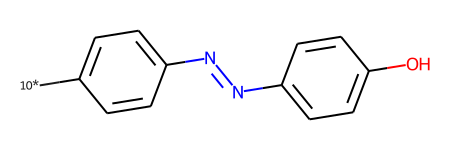

In [221]:
# Now we have our sidechains library. Here is an example of what it looks like. The attachment point of the sidechain 
# is replaced with a carbon isotop for labelling purpose. 
chainlib[2003]

In [127]:
# in the following code, we define a set of functions that perform the following tasks:
# (1) attach two predifined side-chains on two pre-defined positions of a Rhenium-bipyridine complex
# (2) remove the isotop which is a convenient for labelling but not actually present in the side chain
# (3) make an approximate geometry optimization of the molecule, build its xyz coordinates and write them in a 
# user-specified file
# (4) apply (1), (2) and (3) to a user-defined number of randomly generated sets of side-chains and randomly-generated
# attachment position. In final, this creates a set xyz-files describing randomly-generated Re-bipyridin complexes. 
# This will be used for later benchmark of semi-empirical methods.

In [233]:
#randomization-automation procedure
def spawn_Rebpy(chain_library,nchains,nrep):
    #step 1, randomly select a vector containing the chains. We suppose that there are only two lateral chains (one on each pyridine)
    #embedded in the same For loop, we can also figure out a branching for the second chain
    molvec=[]
    for j in range(0,nrep):
        #print(j)
        pickabranch=[0,1,2,5,7,8,9,10]
        Vecchain=[]
        Vecbranch=[]
        Randtrace=[]
        for i in range(0,nchains):
            Randnum=random.randint(0,len(chain_library)-1)
            Randtrace.append(Randnum)
            Randbranch=random.choice(pickabranch)
            Vecchain.append(chain_library[Randnum])
            Vecbranch.append(Randbranch)
            pickabranch.remove(Randbranch)
    # After that we should have random branchment points and random sidechains. We can build the molecule
        mol=mybipybuilder(Vecchain,Vecbranch)
        #print('sidechaines',Randtrace)
        #print('attachment points',Vecbranch)
        mol=isotop_cleaner(mol)
        mol=carbonyls_adder(mol)
        molvec.append(mol)
    
    return molvec

In [235]:
# Builds a bipyridine from a set of side-chains and their attachement position on the bipyridine motif (by index for
# the mol object "smi") stored in two separate vectors. CAREFUL! The isotops are not removed by this function
def mybipybuilder(sidechains,nbrancher):
    smi=Chem.MolFromSmiles('c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2')
    Nats=[]
    Nt=0
    for s1 in sidechains:
        s1=Chem.MolFromSmiles(Chem.MolToSmiles(s1))
        #Nats.append(s1.GetNumAtoms())
        Nt=Nt+s1.GetNumAtoms()
        smi=Chem.CombineMols(s1,smi)
    smitext=Chem.MolToSmiles(smi)
    smi=Chem.MolFromSmiles(smitext)
    #Here get the index of each atom, because the order of appearance of the fragments in the smile is not the same as the order of combination
    #print(smitext)
    smitext=smitext.split('.')
   # print(smitext)
    for ssmi in smitext:
       
        Ndum=Chem.MolFromSmiles(ssmi).GetNumAtoms()

        Nats.append(Chem.MolFromSmiles(ssmi).GetNumAtoms())
  #  print(Nats)
  #  print(smitext)
    smiedit=Chem.EditableMol(smi)
    Attachpoint=0
    smiedit.AddBond(Attachpoint,Nt+nbrancher[0])
   # print('bond formed between',Attachpoint,Nt+nbrancher[0])
    for i in range(1,len(nbrancher)):
     #   print(i,Nats[i-1])
        Attachpoint=Attachpoint+Nats[i-1]
        smiedit.AddBond(Attachpoint,Nt+nbrancher[i])
     #   print('bond formed between',Nats[i-1],Nt+nbrancher[i])
    newsmi=smiedit.GetMol()
   
    return newsmi

In [231]:
# removes the isotopes and atach the isotop neighbours together
def isotop_cleaner(mol):
    #step 1: identify the index of the isotopes
    indx=mol.GetSubstructMatches(Chem.MolFromSmiles('*'))
    indx2=[]
    for i in indx:
        indx2.append(i[0])
    #Step 2: identify the atoms bonded to the isotops
    bound=[]
    j=0
    for i in indx2:
        bound.append([])
        for k in range(0,mol.GetNumAtoms()):
            Hello=mol.GetBondBetweenAtoms(i,k)
            if type(Hello) == Chem.rdchem.Bond:
                bound[j].append(k)
                #print(bound)
        j=j+1
    #Step 3 Now we remove the isotops and reattach the neighbours of the isotops:
    j=0
    moledit=Chem.EditableMol(mol)
    for i in range(0,len(indx)):
        moledit.RemoveAtom(indx2[i])
        # Now we need to change the index in bound if there needs to be
        j=0
        for j in range(0,len(bound)):
         #   print(bound,j)
            if bound[j][0] > indx2[i]:
                bound[j][0]=bound[j][0]-1
            if bound[j][1] > indx2[i]:
                bound[j][1]=bound[j][1]-1
        j=0
        for j in range (i,len(indx)):
            if indx2[j] > indx2[i]:
                indx2[j]=indx2[j]-1
        moledit.AddBond(bound[i][0],bound[i][1])
    mol=moledit.GetMol()
   # mol=Chem.RemoveHs(mol)
    mol2=Chem.MolToSmiles(mol)
    mol2=mol2.replace('~','-')
    mol=Chem.MolFromSmiles(mol2,sanitize=False)
   # mol=Chem.RemoveHs(mol)
    return mol

In [160]:
#Adds the bipyridine to a Re(CO)3 motif.
def carbonyls_adder(mol):
    mol2=Chem.MolToSmiles(mol)
    mol3=mol2.split('[Re]')
    mol2=mol3[0]+'[Re](C#[O+])(C#[O+])(C#[O+])'+mol3[1]
    mol=Chem.MolFromSmiles(mol2)
    return mol

In [223]:
#Before going to the next step, we must also remove the "bidentate" side-chains for simplicity reasons
delete_sick=[]
for i in range(0,len(chainlib)):
    if len(chainlib[i].GetSubstructMatches(Chem.MolFromSmiles('*'))) != 1:
        delete_sick.append(chainlib[i])
        

In [224]:
for i in delete_sick:
    chainlib.remove(i)

In [225]:
len(chainlib)

5613

In [236]:
#Now the random library can be generated
nchains=2
nrep=100
sample=spawn_Rebpy(chainlib,nchains,nrep)

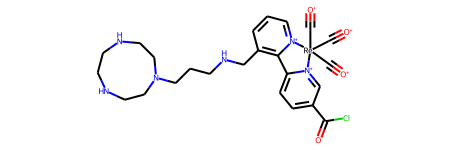

In [237]:
# Here is one example of generated bipyridine:
sample[93]

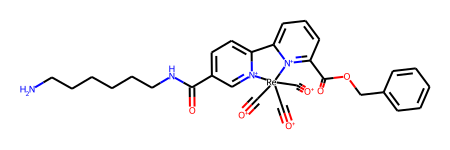

In [238]:
# Another example...
sample[57]

In [178]:
#Finally, we now write the content of the sample list into xyz files in a chosen directory. For that, we create
# an approximate 3D structure using the ETKDG method as implemented in Rdkit. Note that the starting geometry 
# is nowhere near an equilibrium geometry and will require an additionnal geometry optimization. 
# FF optimization with Re is not implemented in Rdkit unfortunately. However, the embedding allows a starting geometry 
# with not-too-awful angles and bond lengths, and most importantly, no overlapping atoms.
# This way, with the appropriate scripts/QM/FF package, the starting geometry can be directly optimized without 
# additional user input.

In [179]:
# write a specified number of xyz files. Also stores the molecules under the form of smiles in a text file 
# in the same folder, as well as a list of the total charge for each complex 
# (CAREFUL:he charge has a systematice error of +5 for each system in the present implementation due to the arbitrary 
# 0 charge of the rhenium) 
def write_xyzfiles(chainlib,nchains,nrep,place):
    try:
        sample=spawn_Rebpy(chainlib,nchains,nrep)
    except:
        pass
    indx=0
    place2=place
    for mol in sample:
        xyz_generator(mol,place,indx)
        indx=indx+1
    smiles_generator(place2,sample)
    return sample

In [180]:
def smiles_generator(place,samp):
    placeX=place+'/smiles-index'
    print(place)
    file1=open(placeX,'w+')
    for sa in samp:
        file1.write(Chem.MolToSmiles(sa)+'\n')
    file1.close()
    placeY=place+'/chargefile'
    file1=open(placeY,'w+')
    for sa in samp:
        file1.write(str(Chem.GetFormalCharge(sa))+'\n')
    file1.close()

In [182]:
# and the proper program to generate and store the 3d structure of a given Mol object
def xyz_generator(mol,place,indx):  
    if type(mol) is not None:
        place=place+'/Rebipy-'+str(indx)+'.xyz'
        mol2=Chem.AddHs(mol)
        N=mol2.GetNumAtoms()
        AllChem.EmbedMolecule(mol2,randomSeed=0xf00d)
        print(Chem.MolToMolBlock(mol2),file=open(place,'w+'))
        #file.close()
        file=open(place,'r')
        lines=file.readlines()
        file.close()
        file=open(place,'w+')
        file.write(str(N)+'\n')
        file.write('This xyz file has been randomly generated!\n')
        for i in range (4,N+4):
            linesp=lines[i].split()
            linetowrite=linesp[3]+' '+linesp[0]+' '+linesp[1]+' '+linesp[2]+'\n'
            file.write(linetowrite)
    else:
        place=place+'/Rebipy-'+str(indx)+'.xyz'
        file=open(place,'w+')
        file.write('Empty mol file :(')
        print('ho-ho, we have a problem...')
    file.close

In [242]:
# Now we can give it a try...
place='/Users/tarrago/Documents/personal-project' #This is where I want my xyzfiles stored
echantillon=write_xyzfiles(chainlib,nchains,nrep,place)

RDKit ERROR: [15:50:36] UFFTYPER: Unrecognized atom type: Re6 (46)
RDKit ERROR: [15:50:36] UFFTYPER: Unrecognized atom type: Re6 (33)
RDKit ERROR: [15:50:36] UFFTYPER: Unrecognized atom type: Re6 (21)
RDKit ERROR: [15:50:36] UFFTYPER: Unrecognized atom type: Re6 (32)
RDKit ERROR: [15:50:37] UFFTYPER: Unrecognized atom type: Re6 (17)
RDKit ERROR: [15:50:37] UFFTYPER: Unrecognized atom type: Re6 (33)
RDKit ERROR: [15:50:37] UFFTYPER: Unrecognized atom type: Re6 (16)
RDKit ERROR: [15:50:37] UFFTYPER: Unrecognized atom type: Re6 (86)
RDKit ERROR: [15:50:39] UFFTYPER: Unrecognized atom type: Re6 (39)
RDKit ERROR: [15:50:39] UFFTYPER: Unrecognized atom type: Re6 (28)
RDKit ERROR: [15:50:39] UFFTYPER: Unrecognized atom type: Re6 (10)
RDKit ERROR: [15:50:39] UFFTYPER: Unrecognized atom type: Re6 (28)
RDKit ERROR: [15:50:39] UFFTYPER: Unrecognized atom type: Re6 (42)
RDKit ERROR: [15:50:40] UFFTYPER: Unrecognized atom type: Re6 (12)
RDKit ERROR: [15:50:40] UFFTYPER: Unrecognized atom type: Re6 

/Users/tarrago/Documents/personal-project


In [243]:
# We can see that the program complains a lot about the Re, as emphasize above. But the rest of the atoms are decently 
# organized, if not optimized. The xyzfiles are stored in the specified diretory, ready to be used by a QM package,
# or visualized with an appropriate software (chemcraft, chimera, avogadto...)
len(echantillon)

100